In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import gpflow
import gpflow.multikernels as mk

/home/mv310/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X = np.random.rand(100)[:, None] * 10 - 5
G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))
Ptrue = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])
Y = np.matmul(G, Ptrue)
Y += np.random.randn(*Y.shape) * [0.2, 0.2, 0.2]

In [3]:
def plot_model(m):
    pX = np.linspace(-6, 6, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_color_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)

# Independent kernel for all outputs -- Independent inducing points

In [4]:
M = 20
K = 3
q_mu = np.zeros((M, K, 1))
q_sqrt = np.tile(np.eye(M)[None, None, :, :], [1, K, 1, 1])
with gpflow.defer_build():
    kern = mk.Independent([gpflow.kernels.RBF(1) + gpflow.kernels.Linear(1) for _ in range(K)])
    feature = mk.IndependentSharedInducingPoints(Z=X[:M, :].copy())
    m = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), feature)
    m.q_mu = gpflow.params.Parameter(q_mu, dtype=gpflow.settings.float_type)
    m.q_sqrt = gpflow.params.Parameter(q_sqrt, dtype=gpflow.settings.float_type)
m.compile()

abc
(?, 1)


In [5]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=30000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 31.117660
  Number of iterations: 6928
  Number of functions evaluations: 7452


In [6]:
m.compute_log_likelihood()

-31.11766045187001

(3, 20, 20)


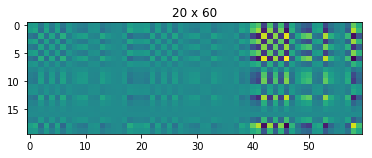

In [7]:
Kmm = m.enquire_session().run(m.feature.Kuu(m.kern))
plt.imshow(Kmm.reshape(M * K, M).T); plt.title("%i x %i" % (M, M * K))
print(Kmm.shape)

In [8]:
print(m.kern)

                                      class prior transform  trainable shape  \
SVGP/kern/sum_1/rbf/variance      Parameter  None       +ve       True    ()   
SVGP/kern/sum_1/rbf/lengthscales  Parameter  None       +ve       True    ()   
SVGP/kern/sum_1/linear/variance   Parameter  None       +ve       True    ()   
SVGP/kern/sum_2/rbf/variance      Parameter  None       +ve       True    ()   
SVGP/kern/sum_2/rbf/lengthscales  Parameter  None       +ve       True    ()   
SVGP/kern/sum_2/linear/variance   Parameter  None       +ve       True    ()   
SVGP/kern/sum_3/rbf/variance      Parameter  None       +ve       True    ()   
SVGP/kern/sum_3/rbf/lengthscales  Parameter  None       +ve       True    ()   
SVGP/kern/sum_3/linear/variance   Parameter  None       +ve       True    ()   

                                  fixed_shape               value  
SVGP/kern/sum_1/rbf/variance             True  0.7432019881138893  
SVGP/kern/sum_1/rbf/lengthscales         True  0.82028139351181

abc
(?, 1)


/home/mv310/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


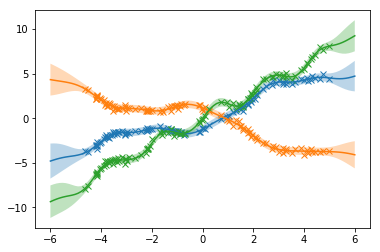

In [9]:
plot_model(m)

# Shared kernel for all outputs
The most basic form of multi-output GP. All GPs are independent in both the prior and posterior. We simply have:
$$
f_i(x) \sim \mathcal{GP}(0, k(x, x')) \\
y_{ni} \mid f_i(x_n) \sim \mathcal{N}(f_i(x_n), \sigma^2) \,.
$$

$K_{uu} \in \mathbb{R}^D$

In [10]:
m = gpflow.models.SVGP(X, Y, gpflow.kernels.RBF(1) + gpflow.kernels.Linear(1),
                       gpflow.likelihoods.Gaussian(), Z=X[:20, :].copy())

abc
(?, 3)


In [11]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=10000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 36.873880
  Number of iterations: 8304
  Number of functions evaluations: 8825


abc
(?, 3)


/home/mv310/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


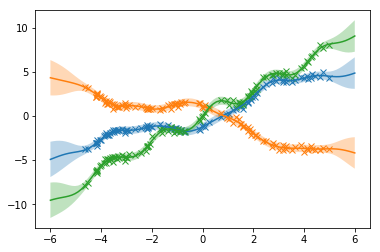

In [12]:
plot_model(m)

In [13]:
print(m.kern)

                                class prior transform  trainable shape  \
SVGP/kern/rbf/variance      Parameter  None       +ve       True    ()   
SVGP/kern/rbf/lengthscales  Parameter  None       +ve       True    ()   
SVGP/kern/linear/variance   Parameter  None       +ve       True    ()   

                            fixed_shape               value  
SVGP/kern/rbf/variance             True  0.7094103072191276  
SVGP/kern/rbf/lengthscales         True  0.7177408329621315  
SVGP/kern/linear/variance          True  1.2223290088593368  


In [14]:
print(m.likelihood)

                              class prior transform  trainable shape  \
SVGP/likelihood/variance  Parameter  None       +ve       True    ()   

                          fixed_shape                value  
SVGP/likelihood/variance         True  0.03889626258489645  


In [15]:
print(m.compute_log_likelihood())

-36.87387961694957


# Independent kernel for all outputs -- Fully correlated inducing points

In [16]:
M = 20
K = 3
q_mu = np.zeros((M, K, 1)).reshape(M * K, 1)
q_sqrt = np.eye(M * K).reshape(1, M, K, M, K).reshape(1, M * K, M * K)
with gpflow.defer_build():
    kern = mk.Independent([gpflow.kernels.RBF(1) + gpflow.kernels.Linear(1) for _ in range(K)])
    feature = mk.MultiInducingPoints(Z=X[:M, :].copy())
    m = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), feature)
    m.q_mu = gpflow.params.Parameter(q_mu, dtype=gpflow.settings.float_type)
    m.q_sqrt = gpflow.params.Parameter(q_sqrt, dtype=gpflow.settings.float_type,
                                       transform=gpflow.transforms.LowerTriangular(M * K, 1))
m.compile()

abc
(?, 1)


In [17]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=10000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 31.117704
  Number of iterations: 7117
  Number of functions evaluations: 7675


abc
(?, 1)


/home/mv310/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


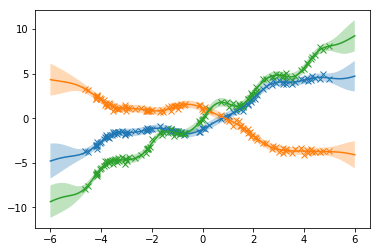

In [18]:
plot_model(m)

In [19]:
print(m.kern)

                                      class prior transform  trainable shape  \
SVGP/kern/sum_1/rbf/variance      Parameter  None       +ve       True    ()   
SVGP/kern/sum_1/rbf/lengthscales  Parameter  None       +ve       True    ()   
SVGP/kern/sum_1/linear/variance   Parameter  None       +ve       True    ()   
SVGP/kern/sum_2/rbf/variance      Parameter  None       +ve       True    ()   
SVGP/kern/sum_2/rbf/lengthscales  Parameter  None       +ve       True    ()   
SVGP/kern/sum_2/linear/variance   Parameter  None       +ve       True    ()   
SVGP/kern/sum_3/rbf/variance      Parameter  None       +ve       True    ()   
SVGP/kern/sum_3/rbf/lengthscales  Parameter  None       +ve       True    ()   
SVGP/kern/sum_3/linear/variance   Parameter  None       +ve       True    ()   

                                  fixed_shape               value  
SVGP/kern/sum_1/rbf/variance             True  0.7428820095533468  
SVGP/kern/sum_1/rbf/lengthscales         True  0.82019712296827

In [20]:
print(m.likelihood)

                              class prior transform  trainable shape  \
SVGP/likelihood/variance  Parameter  None       +ve       True    ()   

                          fixed_shape               value  
SVGP/likelihood/variance         True  0.0386450844356971  


In [21]:
print(m.compute_log_likelihood())

-31.11770382280146


(20, 3, 20, 3)


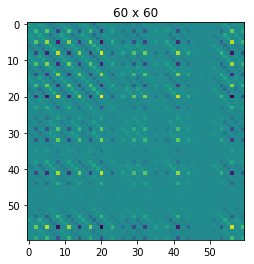

In [22]:
Kmm = m.enquire_session().run(m.feature.Kuu(m.kern))
plt.imshow(Kmm.reshape(M * K, M * K)); plt.title("%i x %i" % (K * M, K * M))
print(Kmm.shape)

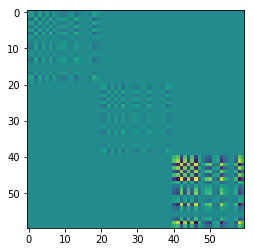

In [23]:
plt.imshow(Kmm.transpose([1, 0, 3, 2]).reshape(M * K, M * K))

# Correlated kernel -- Fully correlated inducing points

In [24]:
M = 20
K = 3
L = 2
q_mu = np.zeros((M, K, 1)).reshape(M * K, 1)
q_sqrt = np.eye(M * K).reshape(1, M, K, M, K).reshape(1, M * K, M * K)
P = np.random.randn(K, L)
with gpflow.defer_build():
    kern = mk.MixedMulti([gpflow.kernels.RBF(1) + gpflow.kernels.Linear(1) for _ in range(L)], P=P)
    feature = mk.MultiInducingPoints(Z=X[:M, :].copy())
    m = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), feature)
    m.q_mu = gpflow.params.Parameter(q_mu, dtype=gpflow.settings.float_type)
    m.q_sqrt = gpflow.params.Parameter(q_sqrt, dtype=gpflow.settings.float_type)
m.compile()

abc
(?, 1)


In [25]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=10000)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: -6.240515
  Number of iterations: 10001
  Number of functions evaluations: 10786


In [26]:
m.compute_log_likelihood()

6.240515066096037

abc
(?, 1)


/home/mv310/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


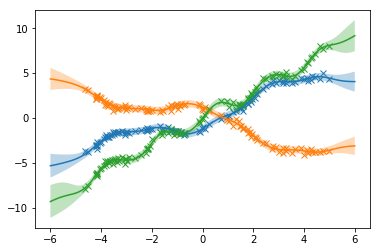

In [27]:
plot_model(m)

(20, 3, 20, 3)


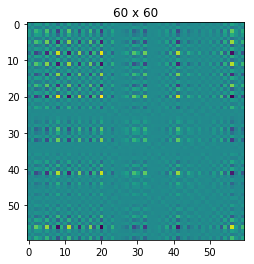

In [28]:
Kmm = m.enquire_session().run(m.feature.Kuu(m.kern))
plt.imshow(Kmm.reshape(M * K, M * K)); plt.title("%i x %i" % (K * M, K * M))
print(Kmm.shape)

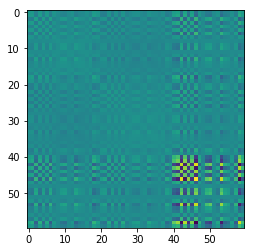

In [29]:
plt.imshow(Kmm.transpose([1, 0, 3, 2]).reshape(M * K, M * K))

# Correlated kernel -- Independent inducing points
Not working yet.

In [30]:
M = 20
K = 3
L = 2
q_mu = np.zeros((M, L, 1))
q_sqrt = np.tile(np.eye(M)[None, None, :, :], [1, L, 1, 1])
P = np.random.randn(K, L)
with gpflow.defer_build():
    kern = mk.MixedMulti([gpflow.kernels.RBF(1) + gpflow.kernels.Linear(1) for _ in range(L)], P=P)
    feature = mk.IndependentSharedInducingPoints(Z=X[:M, :].copy())
    m = gpflow.models.SVGP(X, Y, kern, gpflow.likelihoods.Gaussian(), feature)
    m.q_mu = gpflow.params.Parameter(q_mu, dtype=gpflow.settings.float_type)
    m.q_sqrt = gpflow.params.Parameter(q_sqrt, dtype=gpflow.settings.float_type)
m.compile()

(?, 3)


In [31]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=10000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 76682.125447
  Number of iterations: 474
  Number of functions evaluations: 528


In [32]:
m.compute_log_likelihood()

-76682.12544688207

(?, 3)


/home/mv310/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


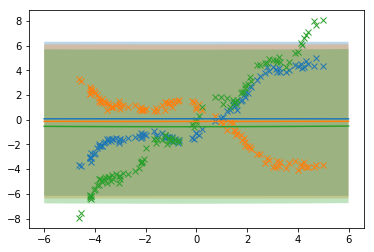

In [33]:
plot_model(m)

In [34]:
Kmm = m.enquire_session().run(m.feature.Kuu(m.kern))
plt.imshow(Kmm.reshape(M * L, M * L)); plt.title("%i x %i" % (L * M, L * M))
print(Kmm.shape)

ValueError: cannot reshape array of size 800 into shape (40,40)